# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План работ**

1. Загрузка и подготовка данных.
2. Обучение и проверка модели для каждого региона:
    * Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
    * Обучите модель и сделайте предсказания на валидационной выборке.
    * Сохраните предсказания и правильные ответы на валидационной выборке.
    * Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
    * Проанализируйте результаты.

    
3. Расчет прибыли:
    * Все ключевые значения для расчётов сохраните в отдельных переменных.
    * Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
    * Напишите выводы по этапу подготовки расчёта прибыли.


4. Сделать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    * Выберите скважины с максимальными значениями предсказаний.
    * Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    * Рассчитайте прибыль для полученного объёма сырья.


5. Посчитать риски и прибыль для каждого региона:
    * Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    * Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    * Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

## Загрузка и подготовка данных

In [1]:
# импортируем модули
import pandas as pd
# Импортируем функцию делить выборку на валидационнную и тренировочную
from sklearn.model_selection import train_test_split
# стандартизация
from sklearn.preprocessing import StandardScaler
# логичтическая регрессия
# матрица ошибок
from sklearn.metrics import confusion_matrix
# Линейная регрессия
from sklearn.linear_model import LinearRegression
# метрика accuracy_score
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Отображение всех столбцов
pd.set_option('display.max_columns', None)
# Два знака после запятой 
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Информация о датсетах: пропуски, дубликаты
def about_data(data):
    print('Информация о датасете: \n')
    print(data.info(), '\n')
    print('Статистические данные: \n')
    print(data.describe(), '\n')
    print('Наличие дубликатов: \n')
    print(data.duplicated().sum(), '\n')
    print('Наличие пропусков: \n')
    print(data.isna().sum(), '\n')    
    print('5 разных строк: \n')
    print(data.sample(5), '\n')

In [5]:
about_data(geo_data_0)

Информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Статистические данные: 

              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        0.50       0.25       2.50      92.50
std         0.87       0.50       3.25      44.29
min        -1.41      -0.85     -12.09       0.00
25%        -0.07      -0.20       0.29      56.50
50%         0.50       0.25       2.52      91.85
75%         1.07       0.70       4.72     128.56
max         2.36       1.34      16.00     185.36 

Наличие дубликатов: 

0 

Наличие пропусков: 

id        

In [6]:
about_data(geo_data_1)

Информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Статистические данные: 

              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        1.14      -4.80       2.49      68.83
std         8.97       5.12       1.70      45.94
min       -31.61     -26.36      -0.02       0.00
25%        -6.30      -8.27       1.00      26.95
50%         1.15      -4.81       2.01      57.09
75%         8.62      -1.33       4.00     107.81
max        29.42      18.73       5.02     137.95 

Наличие дубликатов: 

0 

Наличие пропусков: 

id        

In [7]:
about_data(geo_data_2)

Информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Статистические данные: 

              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        0.00      -0.00       2.50      95.00
std         1.73       1.73       3.47      44.75
min        -8.76      -7.08     -11.97       0.00
25%        -1.16      -1.17       0.13      59.45
50%         0.01      -0.01       2.48      94.93
75%         1.16       1.16       4.86     130.60
max         7.24       7.84      16.74     190.03 

Наличие дубликатов: 

0 

Наличие пропусков: 

id        

Данные геологоразведки трёх регионов подгружены и содержат данные в столбцах:

*	id — уникальный идентификатор скважины;
*	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
*	product — объём запасов в скважине (тыс. баррелей).


Дубликатов не, пропуски данных отсутсвуют



In [8]:
# Количество пустых скважин. Первый датасет
geo_data_0.loc[geo_data_0['product'] == 0].count()

id         1
f0         1
f1         1
f2         1
product    1
dtype: int64

In [9]:
# Количество пустых скважин. Второй датасет
geo_data_1.loc[geo_data_1['product'] == 0].count()

id         8235
f0         8235
f1         8235
f2         8235
product    8235
dtype: int64

In [10]:
# Количество пустых скважин. Третий датасет
geo_data_2.loc[geo_data_2['product'] == 0].count()

id         1
f0         1
f1         1
f2         1
product    1
dtype: int64

Судя по количеству пустых скважин - второй регион самый бедный по наличию нефти в этом случае. 8235  вышек без нефти

In [11]:
# Посмотрим уникальные значения в столбце id  в датасете geo_data_0
len(geo_data_0['id'].unique())

99990

In [12]:
# Посмотрим уникальные значения в столбце id  в датасетах geo_data_1
len(geo_data_1['id'].unique())

99996

In [13]:
# Посмотрим уникальные значения в столбце id  в датасетах geo_data_2
len(geo_data_2['id'].unique())

99996

In [14]:
list_unique_0 = list(geo_data_0['id'].value_counts().head(10).index)
list_unique_1 = list(geo_data_1['id'].value_counts().head(4).index)
list_unique_2 = list(geo_data_2['id'].value_counts().head(4).index)

In [15]:
geo_data_0[geo_data_0['id'].isin(list_unique_0)].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.08,-0.31,6.99,127.64
64022,74z30,0.74,0.46,5.15,140.77
51970,A5aEY,-0.18,0.94,-2.09,33.02
3389,A5aEY,-0.04,0.16,0.21,89.25
69163,AGS9W,-0.93,0.12,-3.66,19.23
42529,AGS9W,1.45,-0.48,0.68,126.37
931,HZww2,0.76,0.37,1.86,30.68
7530,HZww2,1.06,-0.37,10.43,158.83
63593,QcMuo,0.64,-0.47,0.86,64.58
1949,QcMuo,0.51,-0.32,-2.22,75.50


In [16]:
geo_data_1[geo_data_1['id'].isin(list_unique_1)].sort_values('id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.44,-12.30,2.00,57.09
84461,5ltQ6,18.21,2.19,3.99,107.81
1305,LHZR0,11.17,-1.95,3.00,80.86
41906,LHZR0,-8.99,-4.29,2.01,57.09
2721,bfPNe,-9.49,-5.46,4.01,110.99
82178,bfPNe,-6.20,-4.82,3.00,84.04
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82873,wt4Uk,10.26,-9.38,4.99,134.77


In [17]:
geo_data_2[geo_data_2['id'].isin(list_unique_2)].sort_values('id')

,id,f0,f1,f2,product
45404,KUPhW,0.23,-1.70,4.99,11.72
55967,KUPhW,1.21,3.18,5.54,132.83
11449,VF7Jo,2.12,-0.86,5.75,181.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
44378,Vcm5J,-1.23,-2.44,1.22,137.97
95090,Vcm5J,2.59,1.99,2.48,92.33
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39


В трех датасетах есть некоторое значение неуникальных id номеров, но их количечство так мало, что вряд ли они повлияют на обучение модели. Для обучения модели нам не нужен будет id, поэтмоу оставим как есть


Удалим столец id в датасетах

In [18]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

### Вывод

- Были подгружены данные из трех файлов. В каждм наборе по 100000 строк данных
- Во втором датасете много пустых скважин
- Датасеты подготовлены для обучения моделей: из всех трех датасетов был удален столбец id


## Обучение и проверка модели

### Делим данные на обучающую и валидационную выборки в соотношении 75:25.

In [19]:
# Так как датасета три - и везде надо делать деление на выборки, то сделаем функцию

def split_sample(data):
    # стандартизируем данные
    # признаки в переменную
    features = data.drop(['product'], axis=1)
    # целевой признак в переменную
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    print('Обучающая выборка:', features_train.shape, 'в процентах:', round(len(features_train)/len(data)*100, 2),'%')
    print('Валидационная выборка:', features_valid.shape, 'в процентах:', round(len(features_valid)/len(data)*100, 2),'%')
    return features_train, features_valid, target_train, target_valid

In [20]:
# Подготовим признаки и целевые признаки
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_sample(geo_data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_sample(geo_data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_sample(geo_data_2)

Обучающая выборка: (75000, 3) в процентах: 75.0 %
Валидационная выборка: (25000, 3) в процентах: 25.0 %
Обучающая выборка: (75000, 3) в процентах: 75.0 %
Валидационная выборка: (25000, 3) в процентах: 25.0 %
Обучающая выборка: (75000, 3) в процентах: 75.0 %
Валидационная выборка: (25000, 3) в процентах: 25.0 %


### Обучение модели и делаем предсказание на валидационной выборке

In [21]:
model = LinearRegression()
# Функция для обучения модели и вывода метрик
def model_training(features_train, features_valid, target_train, target_valid):
    # Используем логистическую регрессию
    
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)
    print('Доля верных решений (Accuracy):', model.score(features_valid, target_valid))
    return predicted_valid

### Сохраните предсказания и правильные ответы на валидационной выборке

In [22]:
# Первый регион
predicted_valid_0 = model_training(features_train_0, features_valid_0, target_train_0, target_valid_0)


Доля верных решений (Accuracy): 0.27994321524487786


In [23]:
# Второй регион
predicted_valid_1 = model_training(features_train_1, features_valid_1, target_train_1, target_valid_1)


Доля верных решений (Accuracy): 0.9996233978805127


In [24]:
# Тертий регоин
predicted_valid_2 = model_training(features_train_2, features_valid_2, target_train_2, target_valid_2)

Доля верных решений (Accuracy): 0.20524758386040443


###  средний запас предсказанного сырья и RMSE модели.

In [25]:
# Среднее и ошибка
def mean_rmse(answers, predictions):
    mse = mean_squared_error(answers, predictions)
    print('средний запас предсказанного сырья:', predictions.mean())
    print('RMSE:', mse**0.5)

In [26]:
# Первый регион
mean_rmse(target_valid_0, predicted_valid_0)

средний запас предсказанного сырья: 92.59256778438035
RMSE: 37.5794217150813


In [27]:
# Второй регион
mean_rmse(target_valid_1, predicted_valid_1)

средний запас предсказанного сырья: 68.728546895446
RMSE: 0.893099286775617


In [28]:
# Второй регион
mean_rmse(target_valid_2, predicted_valid_2)

средний запас предсказанного сырья: 94.96504596800489
RMSE: 40.02970873393434


### Вывод

* разделили данные на две выборки: тренировочную и валидационную в пропорции 75:25
* Обучили модель для каждого региона
* посчитали среднюю добычу по предсказанным данным и среднеквадратичную ошибку (корень квадратный)
* Лучшую ошибку RMSE показал регион 2. У первого и третьего региона ошибка составляет почти половину предсказанных запасов
* Доля верных решений Accuracy самая лучшая во втором регионе
* Самые большие предсказаные средние запасы сырья в первом и третьем регионе. Второй регион имеет самые малые средние запасы

## Подготовка к расчёту прибыли

### Ключевые значения для расчётов в отдельные переменные.

In [29]:
# Бюджет на разработку скважин в регионе — 10 млрд рублей.
budget = 10000000000
# Доход с каждой единицы продукта 450 тыс
dohod = 450000
# исследуют 500 точек
sampling_well = 500
# выбирают 200 лучших для разработки
best_well = 200
# вероятность убытков меньше 2.5%.
risk = 0.025

In [30]:
# Стоимость скважины в регионе
price_well = budget / best_well
price_well

50000000.0

In [31]:
# Запасы в скважине
min_product = price_well / dohod
min_product

111.11111111111111

### Вывод

* Средний предсказанный запас сырья в скважине меньше, чем нужно для окупаемости
* 111 тыс баррелей - необходимый объем в скважине для окупаемости

## Расчёт прибыли и рисков 

### функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [32]:
# функция по 200 скважинам и предсказаниям модели
def well_profit(target, prediction):
    # преобразуем в Series
    target = pd.Series(target).reset_index(drop=True)

    prediction = pd.Series(prediction).reset_index(drop=True)

    # Отсортируем предсказанный объем по убыванию
    well_sorted = prediction.sort_values(ascending=False)
    # Выберем 200 лучших
    well_select = target[well_sorted.index][:best_well]
    return (well_select.sum() * dohod - budget)

### Расчет прибыли для полученного объёма сырья

In [33]:
print('Прибыль первого региона:', round(well_profit(target_valid_0, predicted_valid_0)/1000000000, 2), 'млрд. руб')

Прибыль первого региона: 3.32 млрд. руб


In [34]:
print('Прибыль второго региона:', round(well_profit(target_valid_1, predicted_valid_1)/1000000000, 2), 'млрд. руб')

Прибыль второго региона: 2.42 млрд. руб


In [35]:
print('Прибыль третьего региона:', round(well_profit(target_valid_2, predicted_valid_2)/1000000000, 2), 'млрд. руб')

Прибыль третьего региона: 2.71 млрд. руб


###  Вывод
Оценивая прибыль, можно сказать что первое место у первого региона, за ним идет третий. Второй регион на третьем месте

## Посчитайте риски и прибыль для каждого региона

### техника  Bootstrap. 1000 выборок

In [40]:
def bootstrap_profit(target, prediction):
    state = np.random.RandomState(12345)
    target = pd.Series(target).reset_index(drop=True)
    prediction = pd.Series(prediction).reset_index(drop=True)    
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=sampling_well, replace=True, random_state=state)
        prediction_subsample = prediction[target_subsample.index]
        values.append(well_profit(target_subsample, prediction_subsample))
    values = pd.Series(values)

    mean_values = values.mean()
    lower = values.quantile(risk)
    # добавил верхнюю границу 97.5%
    upper = values.quantile(0.975)
    # Было:
    #confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    confidence_interval = (lower, upper)
    bankrot_risk = (values < 0).sum() / values.count()
 
    
    print('Средняя прибыль = {:.2f} руб.'.format(mean_values))
    print('95% доверительный интервал руб.', (confidence_interval))
    print('Процент риска {:.1%}'.format(bankrot_risk))
    
    #графическое представление
    values.hist(bins=100, figsize=(16,8))
    plt.xlabel('Доход')
    plt.ylabel('Количество вышек')
    plt.title('Оценка дохода')
    plt.show()

### средняя прибыль, 95%-й доверительный интервал и риск убытков.

Средняя прибыль = 396164984.80 руб.
95% доверительный интервал руб. (-111215545.89049526, 909766941.5534226)
Процент риска 6.9%


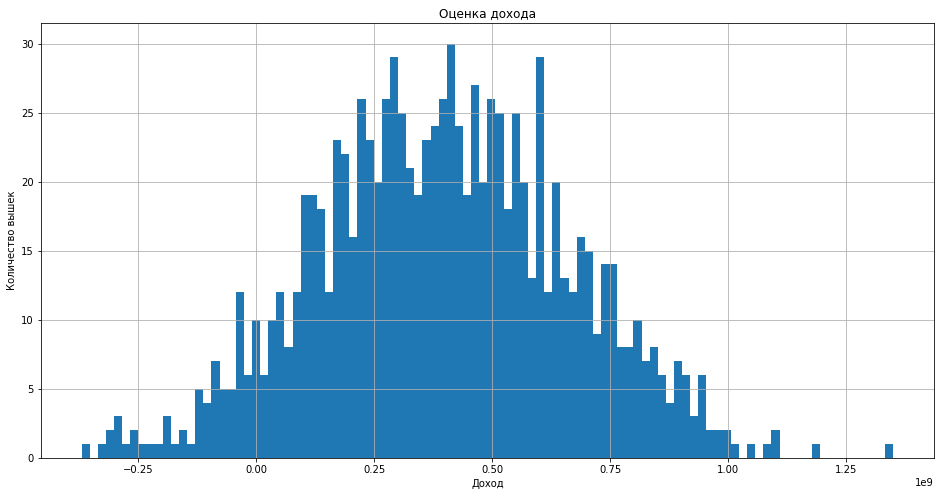

In [41]:
bootstrap_profit(target_valid_0, predicted_valid_0)

Средняя прибыль = 456045105.79 руб.
95% доверительный интервал руб. (33820509.39898363, 852289453.866036)
Процент риска 1.5%


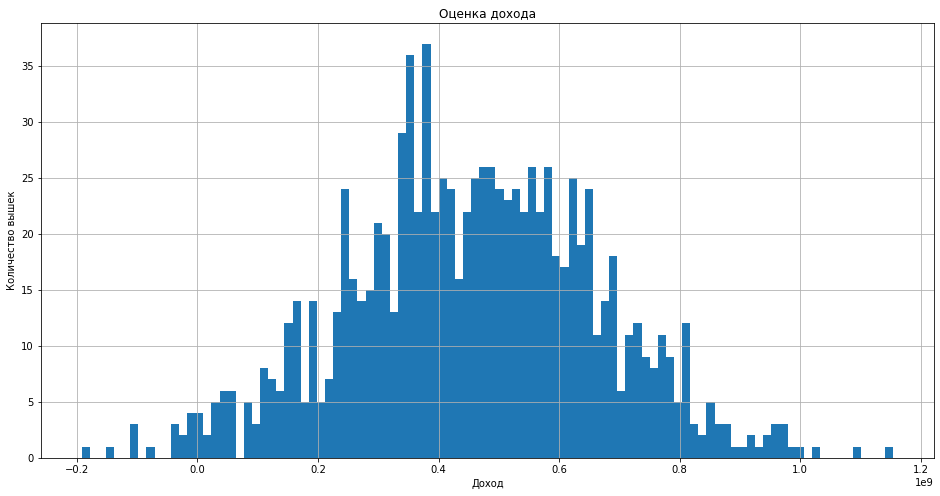

In [42]:
bootstrap_profit(target_valid_1, predicted_valid_1)

Средняя прибыль = 404403866.57 руб.
95% доверительный интервал руб. (-163350413.39560106, 950359574.9237995)
Процент риска 7.6%


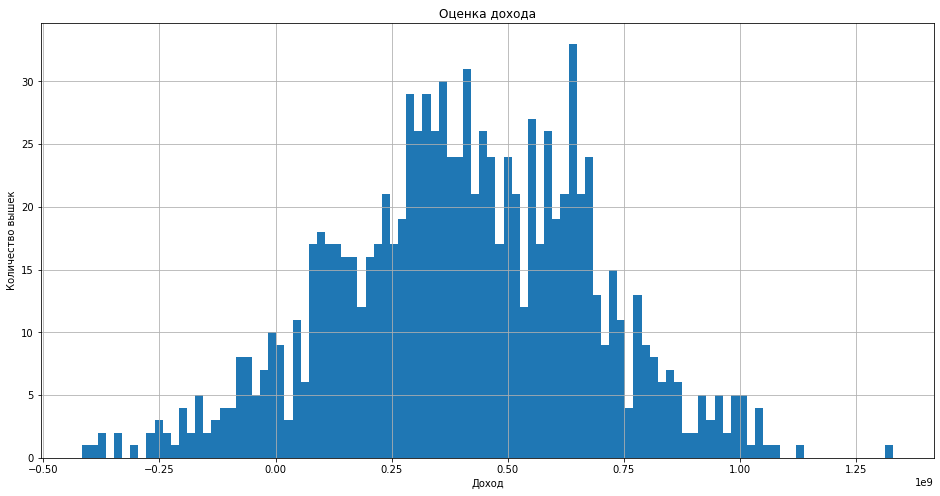

In [43]:
bootstrap_profit(target_valid_2, predicted_valid_2)

По параметру риска подходит второй регион. Самая большая средняя прибыль тоже во втором регионе

## Общий вывод


- Были подгружены данные из трех файлов. В каждм наборе по 100000 строк данных

- Датасеты подготовлены для обучения моделей

* разделили данные на две выборки: тренировочную и валидационную в пропорции 75:25
* Обучили модель для каждого региона
* посчитали среднюю добычу по предсказанным данным и среднеквадратичную ошибку :
    * Первый регион RMSE: 37.57
    * Второй регион RMSE: 0.89
    * Третий регион RMSE: 40.03
* Лучшую ошибку RMSE показал регион 2. У первого и третьего региона ошибка составляет почти половину предсказанных запасов
 
* Средний предсказанный запас сырья в скважине:
    * Первый регион : 92.59
    * Второй регион : 68.72
    * Третий регион : 94.96
* Средний предсказанный запас сырья в скважине меньше, чем нужно для окупаемости .111 тыс баррелей - необходимый объем в скважине.

* По оценкам прибыли регионы можно определить в таком порядке:
    * Прибыль первого региона: 3.32 млрд. руб
    * Прибыль третьего региона: 2.71 млрд. руб
    * Прибыль второго региона: 2.42 млрд. руб

Из трех регионов под условия задачи подходит только второй регион.
    * Вероятность убытков 1,5%, что ниже условия задачи в 2,5%
    * Обученная модель показала на данных этого региона самую лучшую метрику Accuracy = 0.99  и RMSE = 0.89
